# Milestone 4: Deep Learning

## Introduction
Our ultimate goal in this project is to predict movie genres using metadata and posters downloaded from TMDB and IMDB. In this milestone, we mainly focus on extracting features from movie posters using neural network models. We built neural network models to predict position of title on the poster and count the number of faces. These extra features will be add the final model to predict movie genre. We have also attempted to directly classify movie genres using posters. 

## Methods
### Datasets:
We constructed a sample data set of about 6000 movies from 2011-2016 and 124 predictors. The predictors include movie posters and metadata from TMDB and IMDB and counts of common words from movie titles and movie reviews. 

Downloaded predictors (with source): 
- Poster URL (TMDB) 
- Release year (TMDB, factor of 6 levels)
- Release month (TMDB, factor of 12 levels)
- Vote count (TMDB)
- Popularity (TMDB)
- Vote average (TMDB)
- Runtime (IMDB)
- Aspect ratio (IMDB, factor of 22 levels)
- Count of keywords in movie title (TMDB, 17 words with more than 30 total occurrence were selected )
- Count of keywords in movie overview (TMDB, 66 words with more than 200 total occurrence were selected) 

**Manually annotated features**: 
To extract information from posters that may be predictive of movie genre, we also built neural network models to extract additional features from the movie posters. In order to do that, we performed manual annotation of poster features on such as the position of the title and the number of human faces on movies in year 2005-2010, and used these labelled dataset as training data for the neural network models. The models will be used to predict the features on movies from 2011-2016, and the features will be used as predictors for movie genre prediction.
 
- Position of title: we divided poster vertically into thirds and coded the position of the title as being in the top third, middle third, bottom third, or other (not present, vertically oriented, etc.) 
- Number of faces: we only counted human, non-masked faces with discernible eyes. The number of faces was coded as an integer value from 0-10, and 10 for > 10 faces (or hard to count ones). 


## Neural Network Models
We will focus on the neural network models in this milestone. We are performing several classifications using the poster images: position of movie title (t,b,m), number of faces, and genre. 

### Position of Movie Title: 3 classes (excl. other)
We manually scored about 6000 movies from 2005-2010, and labelled the position of the title. The position of the center of the title determines whether the title is on top, middle and bottom ⅓ of the poster. The posters with ambiguous title position were labelled as “other”, such as vertical labels, having labels on both the top and bottom of the poster and etc., and later excluded from the model training. The labels were later read into python and one-hot-encoded to train the neural network models.  


### Number of Faces: values 1 to 10/10+
Similar as position labeling, we also manually counted the number of faces in each poster using the 6000 movies from 2005-2010. 11 categories are defined as the labeling output: 0-9, 10/10+. The first 10 categories represent the exact number of faces that were identifiable in the poster, and the last category encompasses the number of 10 and all above.


### Cross Validation
30% of the training data were used as validation data during the model training. The validation loss was used to decide when to stop the training. We set the patience to 5 for the early stopping, so models with no improvement performance on the validation loss for 5 epochs will be used as the final model.

## From-Scratch Model
To classify title position given poster images, we created a Convolutional Neural Network from scratch that takes 2D posters and outputs a prediction of poster position (top, middle, bottom). We excluded posters with title positions classified as ‘other’ because this category was small (had only about 100 entries) and includes posters with titles both on the top and bottom or in different orientations. To utilize CNNs, we first processed poster images using zero-padding, which resizes the image and allows filters to be applied to elements on image borders, as well as normalization of pixel values to between -1 and 1. After preprocessing the images, we attempted to optimize the network architecture to have high performance accuracy while reducing runtime. 

**Convolutional Neural Nets (CNN)** (https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) are feed-forward networks consisting of layers of convolutional, pooling, and rectified linear units (ReLU) layers followed by fully connected layers that perform well on classification problems. In a CNN, convolutional layers each process a portion of the image, with the response varying based on image characteristics. Unlike multi-layer perceptrons where each neuron is connected to all neurons in the next layer, CNNs have short-range connections between neurons of adjacent layers, forming filters with small receptive fields that extend through the full depth of the input space (https://en.wikipedia.org/wiki/Convolutional_neural_network). Importantly, CNNs capture local dependencies in images and can learn non-linear classifications, so we decided to use CNNs for our image classification problem. 

In [1]:
import numpy as np
import pandas as pd
import cv2  #package for image display
import pickle
from random import shuffle
from sklearn.preprocessing import LabelEncoder

In [2]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras import backend as K

import h5py

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Import and clean the data

In [3]:
#load movie id from 2005-2010
data = pd.read_csv("final_poster_label_2005_2010.csv")
#store movie ID
movieID = data["id"].values

In [4]:
###### read each image and resize 

# total number of posters
n = len(movieID)

# target image size
target_length = 180
target_width = 128

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = movieID[i]
    
    path = 'posters_2005_2010/' + str(movie_id) + '.jpg'
    
    # read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    im = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5963, 180, 128, 3)

In [5]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5963, 180, 128, 3)


In [6]:
# y values: title position
y = data["title_location"].values

# count of different positions
for value in np.unique(y):
    print ("Value: {}, Count: {}.".format(value, len(y[y == value])))
    
# remove 'o' (other) and nan from both x and y
index = (y == 't') + (y == 'b') + (y == 'm') # > 0 if any is true
y = y[index > 0]
print (len(y))

img_matrix = img_matrix[index > 0]
print (img_matrix.shape)

/home/ubuntu/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Value: nan, Count: 0.
Value: b, Count: 1797.
Value: m, Count: 1429.
Value: o, Count: 190.
Value: t, Count: 2545.
5771
(5771, 180, 128, 3)


In [7]:
### preprocessing the data
# shuffle the samples
n = len(y)
index = range(n)
shuffle(index)

y = y[index]
img_matrix = img_matrix[index]

# one-hot-encode y
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

# convert y values to the format for Keras
num_classes = 3
y = keras.utils.to_categorical(y_encoded, num_classes)

### Build the model

In a CNN, **Pooling Layers** are applied to each feature map to down-sample the data, thus reducing the dimensionality of the feature map, controlling overfitting, and smoothing out spatial variations. The Maximum Pooling method gets the largest ReLu value from a small spatial neighborhood of the feature map (for example: 2x2 window). We decided to use a 2x2 filter (very small size) with a stride length of 2 because small filters from size 2x2 to 3x3 along with a smaller stride results in a large feature map and has been shown to have better performance than larger filters. Because Maximum Pooling has been shown to result in better performance than other methods such as Average Pooling, we decided to use this pooling method for image classification. In addition, we decided to use ReLu in activation layers because this function has been shown in previous research to perform better than other nonlinearity functions such as tanh and the sigmoid function.

The network architecture consists of convolutional and rectifier layers followed by pooling layers. To create the network, we used the **Conv2D** function in Keras to make a convolution layer over 2D images For the network depth (number of filters), more filters results in extraction of more image features (performing N convolutions gives N different feature maps). We performed preliminary experiments with up to 5 layers and found that 4 sets of layers in this form resulted in a network that could be trained quickly (within 20 minutes) and had above-baseline performance. 

After the convolutional and pooling layers, the **Fully Connected Layers** in the CNN use the features extracted by the convolutional and pooling layers to perform classification. Fully Connected Layers are analogous to the traditional multi-layered perceptron (http://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips), in which every neuron in a given layer is connected to every neuron in the next layer, where the weights for these connections are learned by the network. We used softmax as the activation function in this part of the layers in order to assign class probabilities to a given sample. We chose parameters such as the number of hidden neurons and number of layers (http://scikit-learn.org/stable/modules/neural_networks_supervised.html) by starting with small numbers (16 neurons, 1 layer) and progressively adding layers in preliminary analysis until we achieve above baseline performance. To prevent the model from overfitting, we used Dropout, a regularization method that randomly drops units from each layer and prevents models from overfitting to the training data, with a parameter of 0.3 because values from 0.2-0.5 have been shown to give good performance in image classification (Srivastava et al. 2014, https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). 


In [23]:
# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

# --- next layer ---
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

# --- next layer ---
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

# --- next layer ---
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))



# flatten for fully connected classification layer
model.add(Flatten()) #lecture note: convert coverlutionary layer to dense layer
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
# --- classification ---
model.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 178, 126, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 87, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 43, 30, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 41, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 18, 12, 16)        4624      
__________

To tune the model, back-propagation updates filter weights and parameter values to minimize some error/loss function. We decided to utilize **Cross-Entropy Loss**, which is commonly used to calculate loss in CNNs. We used Stochastic Gradient Descent (https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to approximate the gradient of the error function, and update model weights. While alternatives such as AdaGrad (different parameters with different learning rates) and Adam (https://arxiv.org/pdf/1412.6980.pdf) (adaptive moment estimation) use different paths to minimize loss (Kingma & Ba 2015, https://arxiv.org/pdf/1412.6980.pdf), our preliminary simulations showed that the loss decreased more slowly in AdaGrad and Adam than in SGD. 


In [24]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.1, momentum=0.9)
adam = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [25]:
# specify the tuning parameters
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 200
# number of iterations over the complete training data
epochs = 50
# add early stopping
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

# we need a callback to save information for tensorboard visualizations
tensorboard = TensorBoard(log_dir='./logs/cv/'+log_dir_string, histogram_freq=1, write_graph=True, write_images=False)

### Tuning the model
Once we decided the number of layer of the models and reasonable filter size, we mainly tune the batch size and learning rate. The number of epochs was set to be a large number, and early stopping with patience of 5 was used to stop the training. The strategy is to try a batch size and learning rate, and using the plots of the loss to decide the direction to further tune the values.  

In [1]:
# fit the model
nnet_title = model.fit(img_matrix, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[earlyStopping],
                    verbose=1,
                    validation_split=0.1)

### Model result
The result from the final model is shown below.

We can see that the training accuracy increases and the training loss decreases as the number of epoch goes up. The performance stops increasing as the training stopped without improvement for 5 epochs.The validation accuracy and loss show a similar but much noiser results. It makes sense because the validation normally have worse performance than the training data, and the dropouts adds more noise while prevents overfitting. If we have more time, we till retrain the data with longer patience for early stopping, so we can see more clearly that the model performance stops improving after 20 epochs. 

**The training accuracy reached 0.6, and the validation accuracy reached 0.52**. It is significantly higher than a random classifier for three categories (0.33). It suggests that our model has a descent performance. 


**Training accuracy:**

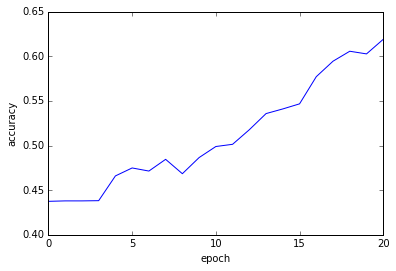

In [19]:
plt.plot(nnet_title.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

**Validation accuracy:**

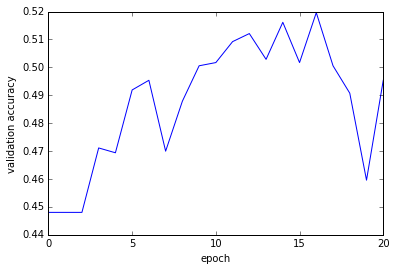

In [20]:
plt.plot(nnet_title.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("validation accuracy")

**Training loss:**

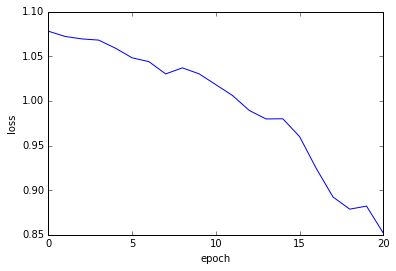

In [21]:
plt.plot(nnet_title.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

**Validation loss:**

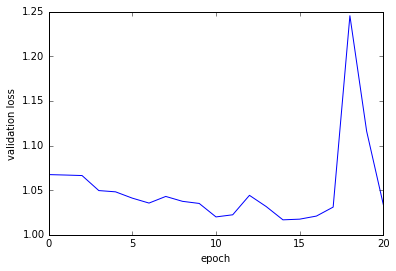

In [22]:
plt.plot(nnet_title.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("validation loss")